In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, ShuffleSplit

Add image here

# Data Loading Tools

Steps 1 and 2

Lulu: make_time_windows and make_x_y is similar to Aisha's data_label_split and data_divide. Differences:
* make_x_y requires a single column to be selected and builds y's from it
* make_time_windows fixes the sequence length and drags the window down each participant's timeseries (not the concatenated npy with all visits)

To do:
* Normalisation/Scaling

In [3]:
def load_DoppelGANger():
  ori_data = pd.read_csv('/content/cat_time_5abovevisits_all.csv') # max timeseries length = 130
  # gen_data = pd.read_csv('/content/gen_doptf2_cat_5abovevisits_e100_lstm.csv') # max timeseries length = 107
  gen_data = pd.read_csv('/content/gen_doptf2_cat_5abovevisits_e200_lstm.csv') # max timeseries length = 111
  ori_data = ori_data.drop(columns=['diar_No', 'diar_Yes', 'head_No', 'head_Yes'])
  gen_data = gen_data.drop(columns=['diar_No', 'diar_Yes', 'head_No', 'head_Yes'])
  ori_data = cat_df_to_3d_array(ori_data, 130) # array (1347, 130, 10)
  gen_data = cat_df_to_3d_array(gen_data, 130) # array (1347, 130, 10)
  return np.nan_to_num(ori_data), np.nan_to_num(gen_data) 

def cat_df_to_3d_array(data, max_length):
  data.fillna(0)
  # max_length = data['id'].value_counts().max() # if you want to get it from the data, but ori/gen may have different max lengths
  lst = []
  for i in data.id.unique():
    timeseries = data[data['id']==i].drop(columns='id').to_numpy()
    length = np.shape(timeseries)[0]
    timeseries = np.pad(timeseries, pad_width=((0,max_length-length), (0,0)), mode='constant') # fill remaining rows with zeros
    lst.append(timeseries)
  array = np.stack(lst)
  return array


def make_time_windows(dataset, w):
  """replaces each participant's 130 long timeseries with all their w length window timeseries
  """
  num_participants, full_length, _ = np.shape(dataset)
  time_windows = []

  for i in list(range(num_participants)): # i = participant's position in dataset

    for j in list(range(full_length-w+1)): # j = row number of first row in window
      time_windows.append(dataset[i,j:j+w,:])

  return np.stack(time_windows)


def make_x_y(dataset, y_index, w):
  """make inputs for model. Note the returned data's sequence length = w-1
    Choose w less than time window length!
  """
  dataset = make_time_windows(dataset, w)
  x = np.delete(dataset, obj=y_index, axis=2) # remove y column from all time series
  x = np.delete(x, obj=-1, axis=1) # remove last row from all time series
  y = dataset[:,1:,[y_index]] # take only y column and remove its earliest cell
  return x, y

Shape Checks:

In [6]:
data = pd.read_csv('/content/gen_doptf2_cat_5abovevisits_e200_lstm.csv')
data['id'].value_counts().max()

111

In [7]:
ori_set, gen_set = load_DoppelGANger()
print([np.shape(_set) for _set in [ori_set, gen_set]])

x, y = make_x_y(ori_set, 0, 129)
print([np.shape(_set) for _set in [x, y]])
print([type(_set) for _set in [x, y]])

[(1347, 130, 6), (1347, 130, 6)]
[(2694, 128, 5), (2694, 128, 1)]
[<class 'numpy.ndarray'>, <class 'numpy.ndarray'>]


# Define Predictive Model

Lulu: moved import statements out of functions and to the top of the document

In [9]:
def last_time_step_mae(Y_true, Y_pred):
  return tf.keras.metrics.MAE(Y_true[:, -1], Y_pred[:, -1])

def make_predictive_model(num_cols):
  input_size = [None,num_cols-1] #
  hidden_dim = num_cols//2 #

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.InputLayer(input_shape=input_size)) # shape = [#timesteps -1, #features=dim-1] per 
  model.add(tf.keras.layers.GRU(hidden_dim, return_sequences=True)) # shape = [#timesteps -1, hidden_dim]
  model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(hidden_dim, activation = "sigmoid")))  # shape = [#timesteps -1, hidden_dim]
  model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1, activation = "linear")))  # output shape = [#timesteps -1, 1]

  model.compile(optimizer = "adam", loss = tf.keras.losses.MeanAbsoluteError(), metrics=[last_time_step_mae])

  return model

# Define Evaluation Scheme

Lulu to do: 
* change args to list//tuple//dict type for easier looping through sets of prameters
* is loss working right? seems proportional to window length. Must normalise beforehand?

In [10]:
def predictive_train_test(train_set, test_set, y_cols='all', windows='max', val_ratio=0.2, batch_size=64, epochs=15, show_training=True):
  """ does the T_T_ portion of the scheme

  Args:
    - train_set, test_set: ori_data, gen_data in order of T_T_ (labels NOT yet split off)
      Make sure train and test are disjoint!
      If doing TSTSvsTRTR then use this function twice
    - y_cols: list of columns to use as target
    - windows: list contains lengths of windows to be used in order of y columns
              NOTE length of input sequences is actually window_length - 1 because of make_x_y
    - val_ratio: validation set ratio split from train_set for use during training
    - batch_size
    - epochs

  Returns:
   - results:
   """



  results = []
  histories = []
  _, max_window, num_columns = np.shape(train_set)
  
  #### for convenience when not tuning parameters
  if y_cols=='all':
    y_cols = list(range(num_columns))

  if windows=='max':
    windows=[max_window]*len(y_cols)
  elif isinstance(windows, int):
      windows=[windows]*len(y_cols)

  for k in range(len(y_cols)): # step 5 (repeating steps 2-4 for each column)
    print('\nPredictive model running for column ', str(y_cols[k]), ' with window length ', str(windows[k]))
    train_x, train_y = make_x_y(train_set, y_cols[k], windows[k]) # step 2
    test_x, test_y = make_x_y(test_set, y_cols[k], windows[k])
    train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=val_ratio)

    model = make_predictive_model(num_columns)
    hist = model.fit(np.asarray(train_x), np.asarray(train_y), batch_size=batch_size, epochs=epochs, validation_data=(val_x, val_y)) # step 4
    print('Getting results for column ', str(y_cols[k]), ' with window length ', str(windows[k]))

    results.append([y_cols[k], windows[k], batch_size, epochs]+model.evaluate(test_x, test_y, batch_size=batch_size))
    histories.append(hist)

    if show_training:
      plt.plot(hist.history['loss'])
      plt.plot(hist.history['val_loss'])
      plt.title('model loss')
      plt.ylabel('loss')
      plt.xlabel('epoch')
      plt.legend(['train loss', 'val loss'], loc='upper right')
      plt.show()

  results_df = pd.DataFrame(results, columns=['y_col', 'window_length', 'batch_size', 'epochs', 'test_loss', 'test_metric'])

  return results_df, histories

# TRTS Example


Predictive model running for column  0  with window length  65
Epoch 1/15
1112/1112 [==============================] - 15s 14ms/step - loss: 6.3136 - last_time_step_mae: 0.7626 - val_loss: 6.1458 - val_last_time_step_mae: 0.7074
Epoch 2/15
1112/1112 [==============================] - 15s 13ms/step - loss: 6.1832 - last_time_step_mae: 0.7371 - val_loss: 5.9869 - val_last_time_step_mae: 0.6778
Epoch 3/15
1112/1112 [==============================] - 15s 13ms/step - loss: 5.9964 - last_time_step_mae: 0.7036 - val_loss: 5.7799 - val_last_time_step_mae: 0.6433
Epoch 4/15
1112/1112 [==============================] - 14s 13ms/step - loss: 5.7699 - last_time_step_mae: 0.6671 - val_loss: 5.5486 - val_last_time_step_mae: 0.6066
Epoch 5/15
1112/1112 [==============================] - 15s 13ms/step - loss: 5.5368 - last_time_step_mae: 0.6315 - val_loss: 5.3261 - val_last_time_step_mae: 0.5737
Epoch 6/15
1112/1112 [==============================] - 15s 13ms/step - loss: 5.3152 - last_time_step_mae:

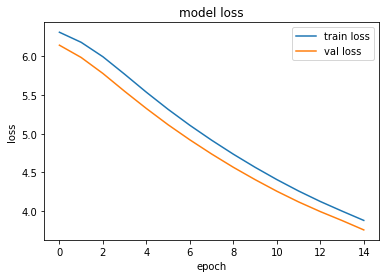


Predictive model running for column  1  with window length  65
Epoch 1/15
1112/1112 [==============================] - 14s 13ms/step - loss: 18.3627 - last_time_step_mae: 3.0893 - val_loss: 18.3459 - val_last_time_step_mae: 2.9167
Epoch 2/15
1112/1112 [==============================] - 14s 13ms/step - loss: 18.3114 - last_time_step_mae: 3.0810 - val_loss: 18.3071 - val_last_time_step_mae: 2.9141
Epoch 3/15
1112/1112 [==============================] - 14s 12ms/step - loss: 18.2697 - last_time_step_mae: 3.0753 - val_loss: 18.2606 - val_last_time_step_mae: 2.9060
Epoch 4/15
1112/1112 [==============================] - 14s 13ms/step - loss: 18.2219 - last_time_step_mae: 3.0682 - val_loss: 18.2097 - val_last_time_step_mae: 2.9000
Epoch 5/15
1112/1112 [==============================] - 14s 12ms/step - loss: 18.1644 - last_time_step_mae: 3.0586 - val_loss: 18.1451 - val_last_time_step_mae: 2.8899
Epoch 6/15
1112/1112 [==============================] - 14s 13ms/step - loss: 18.0946 - last_tim

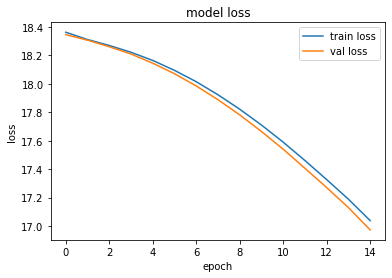


Predictive model running for column  2  with window length  65
Epoch 1/15
1112/1112 [==============================] - 14s 13ms/step - loss: 4.0566 - last_time_step_mae: 0.6416 - val_loss: 3.9031 - val_last_time_step_mae: 0.5784
Epoch 2/15
1112/1112 [==============================] - 14s 12ms/step - loss: 3.9229 - last_time_step_mae: 0.5978 - val_loss: 3.7989 - val_last_time_step_mae: 0.5634
Epoch 3/15
1112/1112 [==============================] - 14s 12ms/step - loss: 3.8142 - last_time_step_mae: 0.5805 - val_loss: 3.6882 - val_last_time_step_mae: 0.5453
Epoch 4/15
1112/1112 [==============================] - 14s 12ms/step - loss: 3.7009 - last_time_step_mae: 0.5625 - val_loss: 3.5743 - val_last_time_step_mae: 0.5279
Epoch 5/15
1112/1112 [==============================] - 14s 12ms/step - loss: 3.5822 - last_time_step_mae: 0.5438 - val_loss: 3.4529 - val_last_time_step_mae: 0.5094
Epoch 6/15
1112/1112 [==============================] - 14s 12ms/step - loss: 3.4537 - last_time_step_mae:

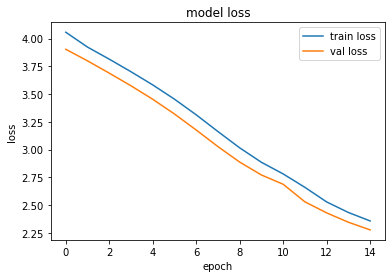


Predictive model running for column  3  with window length  65
Epoch 1/15
1112/1112 [==============================] - 14s 13ms/step - loss: 7.2422 - last_time_step_mae: 1.2303 - val_loss: 7.1309 - val_last_time_step_mae: 1.1713
Epoch 2/15
1112/1112 [==============================] - 14s 12ms/step - loss: 7.0695 - last_time_step_mae: 1.1720 - val_loss: 6.9910 - val_last_time_step_mae: 1.1510
Epoch 3/15
1112/1112 [==============================] - 14s 12ms/step - loss: 6.9228 - last_time_step_mae: 1.1492 - val_loss: 6.8387 - val_last_time_step_mae: 1.1252
Epoch 4/15
1112/1112 [==============================] - 14s 12ms/step - loss: 6.7585 - last_time_step_mae: 1.1224 - val_loss: 6.6611 - val_last_time_step_mae: 1.0958
Epoch 5/15
1112/1112 [==============================] - 14s 12ms/step - loss: 6.5673 - last_time_step_mae: 1.0907 - val_loss: 6.4576 - val_last_time_step_mae: 1.0633
Epoch 6/15
1112/1112 [==============================] - 14s 13ms/step - loss: 6.3528 - last_time_step_mae:

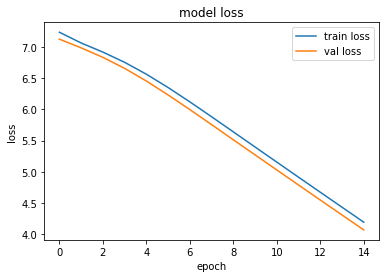


Predictive model running for column  4  with window length  65
Epoch 1/15
1112/1112 [==============================] - 14s 13ms/step - loss: 0.0117 - last_time_step_mae: 0.0016 - val_loss: 0.0099 - val_last_time_step_mae: 0.0022
Epoch 2/15
1112/1112 [==============================] - 14s 13ms/step - loss: 0.0094 - last_time_step_mae: 0.0015 - val_loss: 0.0097 - val_last_time_step_mae: 0.0022
Epoch 3/15
1112/1112 [==============================] - 14s 13ms/step - loss: 0.0093 - last_time_step_mae: 0.0015 - val_loss: 0.0092 - val_last_time_step_mae: 0.0018
Epoch 4/15
1112/1112 [==============================] - 14s 13ms/step - loss: 0.0092 - last_time_step_mae: 0.0015 - val_loss: 0.0098 - val_last_time_step_mae: 0.0024
Epoch 5/15
1112/1112 [==============================] - 14s 12ms/step - loss: 0.0092 - last_time_step_mae: 0.0015 - val_loss: 0.0097 - val_last_time_step_mae: 0.0024
Epoch 6/15
1112/1112 [==============================] - 14s 12ms/step - loss: 0.0091 - last_time_step_mae:

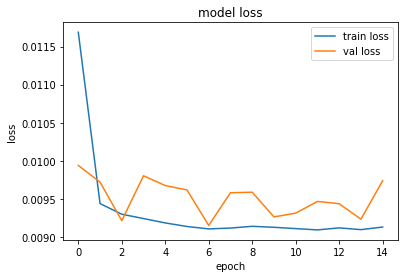


Predictive model running for column  5  with window length  65
Epoch 1/15
1112/1112 [==============================] - 16s 14ms/step - loss: 0.1356 - last_time_step_mae: 0.0214 - val_loss: 0.1266 - val_last_time_step_mae: 0.0186
Epoch 2/15
1112/1112 [==============================] - 15s 14ms/step - loss: 0.1285 - last_time_step_mae: 0.0183 - val_loss: 0.1269 - val_last_time_step_mae: 0.0189
Epoch 3/15
1112/1112 [==============================] - 15s 14ms/step - loss: 0.1283 - last_time_step_mae: 0.0184 - val_loss: 0.1266 - val_last_time_step_mae: 0.0189
Epoch 4/15
1112/1112 [==============================] - 16s 14ms/step - loss: 0.1282 - last_time_step_mae: 0.0184 - val_loss: 0.1264 - val_last_time_step_mae: 0.0187
Epoch 5/15
1112/1112 [==============================] - 15s 13ms/step - loss: 0.1282 - last_time_step_mae: 0.0184 - val_loss: 0.1267 - val_last_time_step_mae: 0.0189
Epoch 6/15
1112/1112 [==============================] - 16s 14ms/step - loss: 0.1282 - last_time_step_mae:

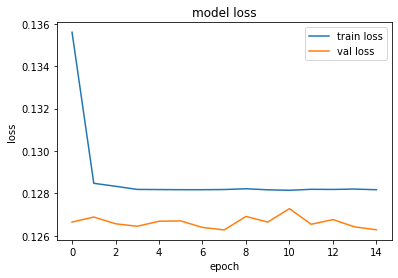

In [11]:
TRTS_results, TRTS_histories = predictive_train_test(ori_set, gen_set, windows=[65,65,65,65,65,65])

In [12]:
TRTS_results

,y_col,window_length,batch_size,epochs,test_loss,test_metric
0,0,65,64,15,16.689686,2.301638
1,1,65,64,15,22.926464,3.402594
2,2,65,64,15,2.604152,0.399332
3,3,65,64,15,4.186219,0.649812
4,4,65,64,15,0.006664,0.001594
5,5,65,64,15,0.044522,0.004782


In [13]:
TRTS_results.to_csv('predictive_trts_dop_results_0827am.csv', index=False)

# TSTR Example


Predictive model running for column  0  with window length  65
Epoch 1/15
1112/1112 [==============================] - 14s 13ms/step - loss: 18.8410 - last_time_step_mae: 2.7561 - val_loss: 18.4797 - val_last_time_step_mae: 2.2538
Epoch 2/15
1112/1112 [==============================] - 14s 13ms/step - loss: 18.6363 - last_time_step_mae: 2.6297 - val_loss: 18.3767 - val_last_time_step_mae: 2.2388
Epoch 3/15
1112/1112 [==============================] - 14s 13ms/step - loss: 18.4716 - last_time_step_mae: 2.6047 - val_loss: 18.1195 - val_last_time_step_mae: 2.2000
Epoch 4/15
1112/1112 [==============================] - 14s 12ms/step - loss: 18.1510 - last_time_step_mae: 2.5567 - val_loss: 17.7805 - val_last_time_step_mae: 2.1472
Epoch 5/15
1112/1112 [==============================] - 14s 12ms/step - loss: 17.8088 - last_time_step_mae: 2.5050 - val_loss: 17.4567 - val_last_time_step_mae: 2.0987
Epoch 6/15
1112/1112 [==============================] - 15s 13ms/step - loss: 17.5252 - last_tim

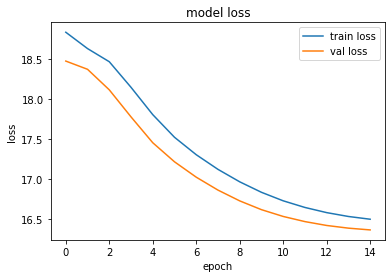


Predictive model running for column  1  with window length  65
Epoch 1/15
1112/1112 [==============================] - 15s 13ms/step - loss: 25.4900 - last_time_step_mae: 3.7648 - val_loss: 25.5355 - val_last_time_step_mae: 3.9613
Epoch 2/15
1112/1112 [==============================] - 14s 13ms/step - loss: 25.1274 - last_time_step_mae: 3.7033 - val_loss: 25.0877 - val_last_time_step_mae: 3.8884
Epoch 3/15
1112/1112 [==============================] - 14s 13ms/step - loss: 24.6723 - last_time_step_mae: 3.6356 - val_loss: 24.6203 - val_last_time_step_mae: 3.8124
Epoch 4/15
1112/1112 [==============================] - 14s 13ms/step - loss: 24.2089 - last_time_step_mae: 3.5647 - val_loss: 24.1499 - val_last_time_step_mae: 3.7359
Epoch 5/15
1112/1112 [==============================] - 15s 13ms/step - loss: 23.7456 - last_time_step_mae: 3.4947 - val_loss: 23.6814 - val_last_time_step_mae: 3.6596
Epoch 6/15
1112/1112 [==============================] - 14s 13ms/step - loss: 23.2840 - last_tim

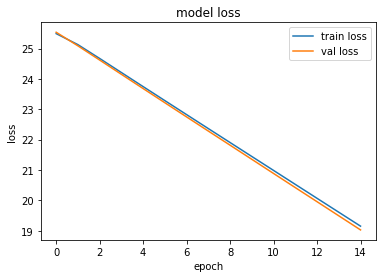


Predictive model running for column  2  with window length  65
Epoch 1/15
1112/1112 [==============================] - 14s 13ms/step - loss: 5.2661 - last_time_step_mae: 0.8557 - val_loss: 4.9030 - val_last_time_step_mae: 0.7017
Epoch 2/15
1112/1112 [==============================] - 14s 12ms/step - loss: 4.7439 - last_time_step_mae: 0.7427 - val_loss: 4.3564 - val_last_time_step_mae: 0.6227
Epoch 3/15
1112/1112 [==============================] - 14s 13ms/step - loss: 4.1464 - last_time_step_mae: 0.6500 - val_loss: 3.7706 - val_last_time_step_mae: 0.5391
Epoch 4/15
1112/1112 [==============================] - 14s 13ms/step - loss: 3.6233 - last_time_step_mae: 0.5677 - val_loss: 3.3299 - val_last_time_step_mae: 0.4764
Epoch 5/15
1112/1112 [==============================] - 14s 13ms/step - loss: 3.2144 - last_time_step_mae: 0.5035 - val_loss: 2.9729 - val_last_time_step_mae: 0.4262
Epoch 6/15
1112/1112 [==============================] - 14s 13ms/step - loss: 2.8810 - last_time_step_mae:

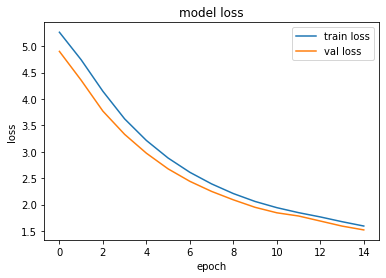


Predictive model running for column  3  with window length  65
Epoch 1/15
1112/1112 [==============================] - 15s 13ms/step - loss: 7.5800 - last_time_step_mae: 1.2123 - val_loss: 7.4455 - val_last_time_step_mae: 1.1451
Epoch 2/15
1112/1112 [==============================] - 14s 13ms/step - loss: 7.3814 - last_time_step_mae: 1.1413 - val_loss: 7.2809 - val_last_time_step_mae: 1.1213
Epoch 3/15
1112/1112 [==============================] - 14s 13ms/step - loss: 7.2061 - last_time_step_mae: 1.1146 - val_loss: 7.0959 - val_last_time_step_mae: 1.0939
Epoch 4/15
1112/1112 [==============================] - 14s 13ms/step - loss: 7.0058 - last_time_step_mae: 1.0835 - val_loss: 6.8795 - val_last_time_step_mae: 1.0592
Epoch 5/15
1112/1112 [==============================] - 14s 13ms/step - loss: 6.7774 - last_time_step_mae: 1.0482 - val_loss: 6.6405 - val_last_time_step_mae: 1.0235
Epoch 6/15
1112/1112 [==============================] - 14s 13ms/step - loss: 6.5301 - last_time_step_mae:

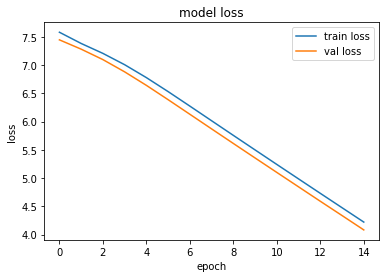


Predictive model running for column  4  with window length  65
Epoch 1/15
1112/1112 [==============================] - 15s 13ms/step - loss: 0.0945 - last_time_step_mae: 0.0788 - val_loss: 0.0090 - val_last_time_step_mae: 0.0020
Epoch 2/15
1112/1112 [==============================] - 14s 13ms/step - loss: 0.0079 - last_time_step_mae: 0.0015 - val_loss: 0.0082 - val_last_time_step_mae: 0.0018
Epoch 3/15
1112/1112 [==============================] - 14s 13ms/step - loss: 0.0074 - last_time_step_mae: 0.0014 - val_loss: 0.0081 - val_last_time_step_mae: 0.0020
Epoch 4/15
1112/1112 [==============================] - 14s 13ms/step - loss: 0.0072 - last_time_step_mae: 0.0014 - val_loss: 0.0072 - val_last_time_step_mae: 0.0011
Epoch 5/15
1112/1112 [==============================] - 14s 13ms/step - loss: 0.0070 - last_time_step_mae: 0.0014 - val_loss: 0.0076 - val_last_time_step_mae: 0.0018
Epoch 6/15
1112/1112 [==============================] - 14s 13ms/step - loss: 0.0069 - last_time_step_mae:

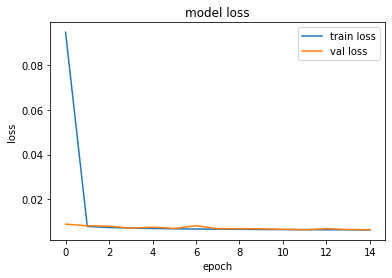


Predictive model running for column  5  with window length  65
Epoch 1/15
1112/1112 [==============================] - 15s 13ms/step - loss: 0.0991 - last_time_step_mae: 0.0686 - val_loss: 0.0423 - val_last_time_step_mae: 0.0041
Epoch 2/15
1112/1112 [==============================] - 14s 13ms/step - loss: 0.0420 - last_time_step_mae: 0.0045 - val_loss: 0.0412 - val_last_time_step_mae: 0.0042
Epoch 3/15
1112/1112 [==============================] - 14s 13ms/step - loss: 0.0411 - last_time_step_mae: 0.0044 - val_loss: 0.0405 - val_last_time_step_mae: 0.0041
Epoch 4/15
1112/1112 [==============================] - 14s 13ms/step - loss: 0.0407 - last_time_step_mae: 0.0044 - val_loss: 0.0405 - val_last_time_step_mae: 0.0045
Epoch 5/15
1112/1112 [==============================] - 14s 12ms/step - loss: 0.0403 - last_time_step_mae: 0.0044 - val_loss: 0.0402 - val_last_time_step_mae: 0.0045
Epoch 6/15
1112/1112 [==============================] - 14s 13ms/step - loss: 0.0400 - last_time_step_mae:

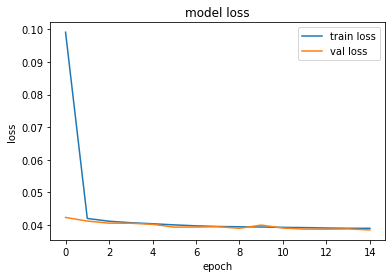

In [21]:
TSTR_results, TSTR_histories = predictive_train_test(gen_set, ori_set, windows=65)

In [22]:
TSTR_results

,y_col,window_length,batch_size,epochs,test_loss,test_metric
0,0,65,64,15,3.612199,0.314428
1,1,65,64,15,15.221030,2.555632
2,2,65,64,15,2.353104,0.410541
3,3,65,64,15,4.019885,0.678334
4,4,65,64,15,0.032840,0.009433
5,5,65,64,15,0.131415,0.018768


In [23]:
TSTR_results.to_csv('predictive_tstr_dop_results_0827am.csv', index=False)

# TRTR vs TSTS Example


Predictive model running for column  0  with window length  65
Epoch 1/20
556/556 [==============================] - 7s 13ms/step - loss: 6.2423 - last_time_step_mae: 0.8425 - val_loss: 6.0053 - val_last_time_step_mae: 0.6020
Epoch 2/20
556/556 [==============================] - 7s 13ms/step - loss: 5.9059 - last_time_step_mae: 0.6522 - val_loss: 5.7641 - val_last_time_step_mae: 0.5681
Epoch 3/20
556/556 [==============================] - 7s 12ms/step - loss: 5.6728 - last_time_step_mae: 0.6179 - val_loss: 5.5396 - val_last_time_step_mae: 0.5367
Epoch 4/20
556/556 [==============================] - 7s 12ms/step - loss: 5.4540 - last_time_step_mae: 0.5866 - val_loss: 5.3277 - val_last_time_step_mae: 0.5089
Epoch 5/20
556/556 [==============================] - 7s 12ms/step - loss: 5.2487 - last_time_step_mae: 0.5571 - val_loss: 5.1286 - val_last_time_step_mae: 0.4823
Epoch 6/20
556/556 [==============================] - 7s 12ms/step - loss: 5.0574 - last_time_step_mae: 0.5298 - val_loss

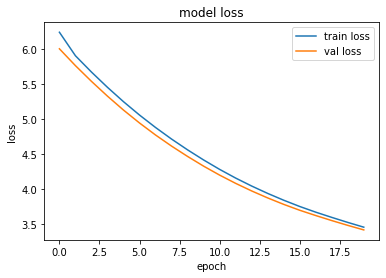


Predictive model running for column  1  with window length  65
Epoch 1/20
556/556 [==============================] - 7s 13ms/step - loss: 18.5004 - last_time_step_mae: 2.8757 - val_loss: 18.5554 - val_last_time_step_mae: 2.9642
Epoch 2/20
556/556 [==============================] - 7s 12ms/step - loss: 18.4739 - last_time_step_mae: 2.8718 - val_loss: 18.5348 - val_last_time_step_mae: 2.9609
Epoch 3/20
556/556 [==============================] - 7s 12ms/step - loss: 18.4535 - last_time_step_mae: 2.8688 - val_loss: 18.5141 - val_last_time_step_mae: 2.9577
Epoch 4/20
556/556 [==============================] - 7s 12ms/step - loss: 18.4318 - last_time_step_mae: 2.8655 - val_loss: 18.4914 - val_last_time_step_mae: 2.9545
Epoch 5/20
556/556 [==============================] - 7s 12ms/step - loss: 18.4076 - last_time_step_mae: 2.8619 - val_loss: 18.4655 - val_last_time_step_mae: 2.9501
Epoch 6/20
556/556 [==============================] - 7s 12ms/step - loss: 18.3805 - last_time_step_mae: 2.8579

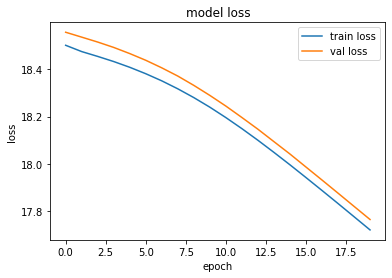


Predictive model running for column  2  with window length  65
Epoch 1/20
556/556 [==============================] - 7s 13ms/step - loss: 4.2092 - last_time_step_mae: 0.7316 - val_loss: 4.1731 - val_last_time_step_mae: 0.6629
Epoch 2/20
556/556 [==============================] - 7s 12ms/step - loss: 4.0560 - last_time_step_mae: 0.5934 - val_loss: 4.1557 - val_last_time_step_mae: 0.6613
Epoch 3/20
556/556 [==============================] - 7s 12ms/step - loss: 4.0374 - last_time_step_mae: 0.5912 - val_loss: 4.1356 - val_last_time_step_mae: 0.6571
Epoch 4/20
556/556 [==============================] - 7s 13ms/step - loss: 4.0181 - last_time_step_mae: 0.5887 - val_loss: 4.1136 - val_last_time_step_mae: 0.6556
Epoch 5/20
556/556 [==============================] - 7s 13ms/step - loss: 3.9970 - last_time_step_mae: 0.5865 - val_loss: 4.0971 - val_last_time_step_mae: 0.6519
Epoch 6/20
556/556 [==============================] - 7s 12ms/step - loss: 3.9808 - last_time_step_mae: 0.5839 - val_loss

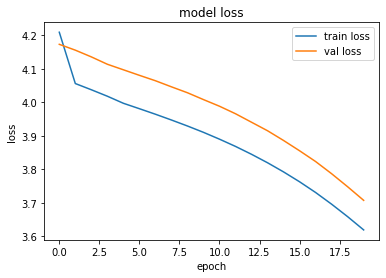


Predictive model running for column  3  with window length  65
Epoch 1/20
556/556 [==============================] - 7s 13ms/step - loss: 7.2450 - last_time_step_mae: 1.0998 - val_loss: 7.1803 - val_last_time_step_mae: 1.0769
Epoch 2/20
556/556 [==============================] - 7s 12ms/step - loss: 7.0928 - last_time_step_mae: 1.0536 - val_loss: 7.0327 - val_last_time_step_mae: 1.0557
Epoch 3/20
556/556 [==============================] - 7s 12ms/step - loss: 6.9302 - last_time_step_mae: 1.0300 - val_loss: 6.8551 - val_last_time_step_mae: 1.0311
Epoch 4/20
556/556 [==============================] - 7s 12ms/step - loss: 6.7394 - last_time_step_mae: 1.0023 - val_loss: 6.6516 - val_last_time_step_mae: 1.0016
Epoch 5/20
556/556 [==============================] - 7s 12ms/step - loss: 6.5283 - last_time_step_mae: 0.9712 - val_loss: 6.4329 - val_last_time_step_mae: 0.9705
Epoch 6/20
556/556 [==============================] - 7s 12ms/step - loss: 6.3059 - last_time_step_mae: 0.9383 - val_loss

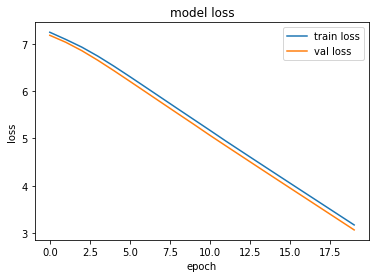


Predictive model running for column  4  with window length  65
Epoch 1/20
556/556 [==============================] - 7s 13ms/step - loss: 0.0928 - last_time_step_mae: 0.0767 - val_loss: 0.0108 - val_last_time_step_mae: 0.0026
Epoch 2/20
556/556 [==============================] - 7s 12ms/step - loss: 0.0103 - last_time_step_mae: 0.0021 - val_loss: 0.0094 - val_last_time_step_mae: 0.0020
Epoch 3/20
556/556 [==============================] - 7s 12ms/step - loss: 0.0094 - last_time_step_mae: 0.0018 - val_loss: 0.0088 - val_last_time_step_mae: 0.0019
Epoch 4/20
556/556 [==============================] - 7s 12ms/step - loss: 0.0088 - last_time_step_mae: 0.0016 - val_loss: 0.0086 - val_last_time_step_mae: 0.0019
Epoch 5/20
556/556 [==============================] - 7s 12ms/step - loss: 0.0088 - last_time_step_mae: 0.0016 - val_loss: 0.0087 - val_last_time_step_mae: 0.0020
Epoch 6/20
556/556 [==============================] - 7s 12ms/step - loss: 0.0088 - last_time_step_mae: 0.0016 - val_loss

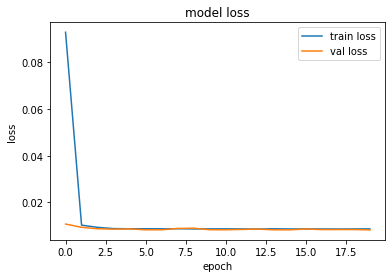


Predictive model running for column  5  with window length  65
Epoch 1/20
556/556 [==============================] - 7s 13ms/step - loss: 0.3263 - last_time_step_mae: 0.2058 - val_loss: 0.1484 - val_last_time_step_mae: 0.0168
Epoch 2/20
556/556 [==============================] - 7s 12ms/step - loss: 0.1462 - last_time_step_mae: 0.0163 - val_loss: 0.1439 - val_last_time_step_mae: 0.0162
Epoch 3/20
556/556 [==============================] - 7s 12ms/step - loss: 0.1424 - last_time_step_mae: 0.0160 - val_loss: 0.1406 - val_last_time_step_mae: 0.0159
Epoch 4/20
556/556 [==============================] - 7s 12ms/step - loss: 0.1393 - last_time_step_mae: 0.0156 - val_loss: 0.1376 - val_last_time_step_mae: 0.0157
Epoch 5/20
556/556 [==============================] - 7s 12ms/step - loss: 0.1367 - last_time_step_mae: 0.0155 - val_loss: 0.1352 - val_last_time_step_mae: 0.0157
Epoch 6/20
556/556 [==============================] - 7s 12ms/step - loss: 0.1322 - last_time_step_mae: 0.0154 - val_loss

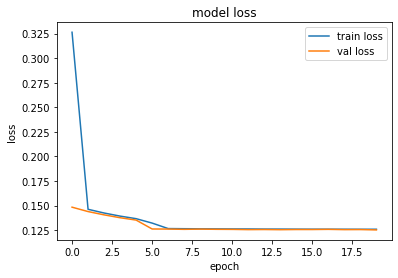


Predictive model running for column  0  with window length  65
Epoch 1/20
556/556 [==============================] - 7s 13ms/step - loss: 17.0772 - last_time_step_mae: 2.2079 - val_loss: 16.8193 - val_last_time_step_mae: 2.3456
Epoch 2/20
556/556 [==============================] - 7s 12ms/step - loss: 16.9808 - last_time_step_mae: 2.1792 - val_loss: 16.7118 - val_last_time_step_mae: 2.3288
Epoch 3/20
556/556 [==============================] - 7s 12ms/step - loss: 16.8739 - last_time_step_mae: 2.1644 - val_loss: 16.6024 - val_last_time_step_mae: 2.3118
Epoch 4/20
556/556 [==============================] - 7s 12ms/step - loss: 16.7573 - last_time_step_mae: 2.1487 - val_loss: 16.4781 - val_last_time_step_mae: 2.2912
Epoch 5/20
556/556 [==============================] - 7s 12ms/step - loss: 16.6330 - last_time_step_mae: 2.1312 - val_loss: 16.3511 - val_last_time_step_mae: 2.2712
Epoch 6/20
556/556 [==============================] - 7s 12ms/step - loss: 16.5102 - last_time_step_mae: 2.1145

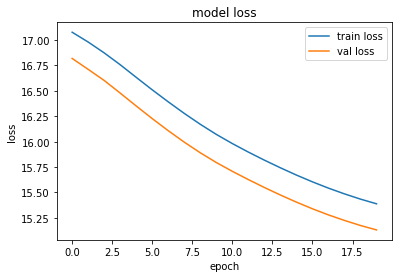


Predictive model running for column  1  with window length  65
Epoch 1/20
556/556 [==============================] - 7s 13ms/step - loss: 24.2487 - last_time_step_mae: 3.6080 - val_loss: 24.6123 - val_last_time_step_mae: 3.6105
Epoch 2/20
556/556 [==============================] - 7s 12ms/step - loss: 24.1222 - last_time_step_mae: 3.5380 - val_loss: 24.5065 - val_last_time_step_mae: 3.5941
Epoch 3/20
556/556 [==============================] - 7s 12ms/step - loss: 24.0007 - last_time_step_mae: 3.5195 - val_loss: 24.3647 - val_last_time_step_mae: 3.5720
Epoch 4/20
556/556 [==============================] - 7s 12ms/step - loss: 23.8449 - last_time_step_mae: 3.4961 - val_loss: 24.1906 - val_last_time_step_mae: 3.5457
Epoch 5/20
556/556 [==============================] - 7s 12ms/step - loss: 23.6616 - last_time_step_mae: 3.4682 - val_loss: 23.9928 - val_last_time_step_mae: 3.5146
Epoch 6/20
556/556 [==============================] - 7s 12ms/step - loss: 23.4600 - last_time_step_mae: 3.4372

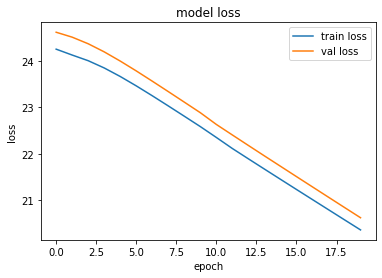


Predictive model running for column  2  with window length  65
Epoch 1/20
556/556 [==============================] - 7s 13ms/step - loss: 5.2060 - last_time_step_mae: 0.8540 - val_loss: 5.1215 - val_last_time_step_mae: 0.7448
Epoch 2/20
556/556 [==============================] - 7s 13ms/step - loss: 5.0771 - last_time_step_mae: 0.7549 - val_loss: 5.0737 - val_last_time_step_mae: 0.7386
Epoch 3/20
556/556 [==============================] - 7s 12ms/step - loss: 5.0238 - last_time_step_mae: 0.7471 - val_loss: 5.0138 - val_last_time_step_mae: 0.7293
Epoch 4/20
556/556 [==============================] - 7s 12ms/step - loss: 4.9607 - last_time_step_mae: 0.7374 - val_loss: 4.9471 - val_last_time_step_mae: 0.7205
Epoch 5/20
556/556 [==============================] - 7s 12ms/step - loss: 4.8913 - last_time_step_mae: 0.7269 - val_loss: 4.8729 - val_last_time_step_mae: 0.7079
Epoch 6/20
556/556 [==============================] - 7s 12ms/step - loss: 4.8168 - last_time_step_mae: 0.7155 - val_loss

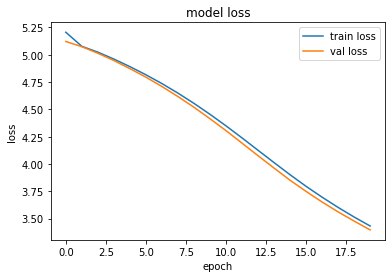


Predictive model running for column  3  with window length  65
Epoch 1/20
556/556 [==============================] - 7s 13ms/step - loss: 7.0951 - last_time_step_mae: 1.1003 - val_loss: 6.9768 - val_last_time_step_mae: 1.0620
Epoch 2/20
556/556 [==============================] - 7s 12ms/step - loss: 6.9490 - last_time_step_mae: 1.0552 - val_loss: 6.8567 - val_last_time_step_mae: 1.0433
Epoch 3/20
556/556 [==============================] - 7s 12ms/step - loss: 6.8236 - last_time_step_mae: 1.0363 - val_loss: 6.7276 - val_last_time_step_mae: 1.0240
Epoch 4/20
556/556 [==============================] - 7s 12ms/step - loss: 6.6867 - last_time_step_mae: 1.0158 - val_loss: 6.5834 - val_last_time_step_mae: 1.0013
Epoch 5/20
556/556 [==============================] - 7s 12ms/step - loss: 6.5341 - last_time_step_mae: 0.9920 - val_loss: 6.4230 - val_last_time_step_mae: 0.9762
Epoch 6/20
556/556 [==============================] - 7s 12ms/step - loss: 6.3653 - last_time_step_mae: 0.9665 - val_loss

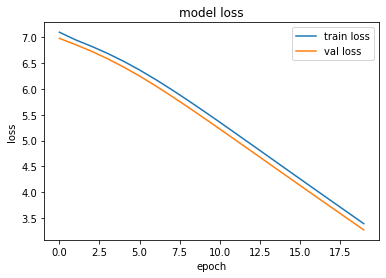


Predictive model running for column  4  with window length  65
Epoch 1/20
556/556 [==============================] - 8s 14ms/step - loss: 0.2015 - last_time_step_mae: 0.1876 - val_loss: 0.0070 - val_last_time_step_mae: 5.9970e-04
Epoch 2/20
556/556 [==============================] - 7s 13ms/step - loss: 0.0065 - last_time_step_mae: 6.4467e-04 - val_loss: 0.0064 - val_last_time_step_mae: 9.8335e-04
Epoch 3/20
556/556 [==============================] - 7s 12ms/step - loss: 0.0059 - last_time_step_mae: 6.4189e-04 - val_loss: 0.0055 - val_last_time_step_mae: 2.3634e-04
Epoch 4/20
556/556 [==============================] - 7s 13ms/step - loss: 0.0057 - last_time_step_mae: 6.5593e-04 - val_loss: 0.0057 - val_last_time_step_mae: 8.2977e-04
Epoch 5/20
556/556 [==============================] - 7s 13ms/step - loss: 0.0055 - last_time_step_mae: 7.1338e-04 - val_loss: 0.0053 - val_last_time_step_mae: 4.4035e-04
Epoch 6/20
556/556 [==============================] - 7s 13ms/step - loss: 0.0054 - l

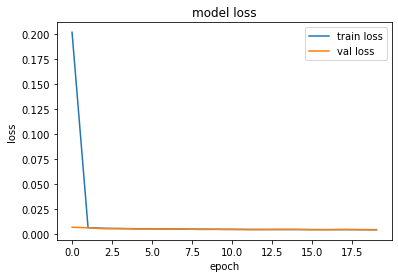


Predictive model running for column  5  with window length  65
Epoch 1/20
556/556 [==============================] - 7s 13ms/step - loss: 0.0478 - last_time_step_mae: 0.0142 - val_loss: 0.0414 - val_last_time_step_mae: 0.0049
Epoch 2/20
556/556 [==============================] - 7s 13ms/step - loss: 0.0385 - last_time_step_mae: 0.0049 - val_loss: 0.0408 - val_last_time_step_mae: 0.0049
Epoch 3/20
556/556 [==============================] - 7s 13ms/step - loss: 0.0381 - last_time_step_mae: 0.0047 - val_loss: 0.0408 - val_last_time_step_mae: 0.0052
Epoch 4/20
556/556 [==============================] - 7s 13ms/step - loss: 0.0380 - last_time_step_mae: 0.0047 - val_loss: 0.0406 - val_last_time_step_mae: 0.0051
Epoch 5/20
556/556 [==============================] - 7s 13ms/step - loss: 0.0380 - last_time_step_mae: 0.0048 - val_loss: 0.0410 - val_last_time_step_mae: 0.0055
Epoch 6/20
556/556 [==============================] - 7s 13ms/step - loss: 0.0381 - last_time_step_mae: 0.0049 - val_loss

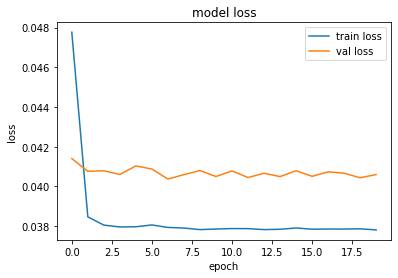

In [15]:
train_ori_set, test_ori_set = train_test_split(ori_set, train_size=0.5)
TRTR_results, TRTR_histories = predictive_train_test(train_ori_set, test_ori_set, windows=65, epochs=20)

train_gen_set, test_gen_set = train_test_split(gen_set, train_size=0.5)
TSTS_results, TSTS_histories = predictive_train_test(train_gen_set, test_gen_set, windows=65, epochs=20)

In [16]:
TRTR_results

,y_col,window_length,batch_size,epochs,test_loss,test_metric
0,0,65,64,20,3.353052,0.317611
1,1,65,64,20,17.510838,3.097426
2,2,65,64,20,3.607972,0.552228
3,3,65,64,20,3.018673,0.557123
4,4,65,64,20,0.009431,0.001232
5,5,65,64,20,0.129643,0.021199


In [17]:
TRTR_results.to_csv('predictive_trtr_dop_results_0827am.csv', index=False)

In [18]:
TSTS_results

,y_col,window_length,batch_size,epochs,test_loss,test_metric
0,0,65,64,20,18.059305,2.582109
1,1,65,64,20,22.324053,3.355883
2,2,65,64,20,3.735698,0.600151
3,3,65,64,20,3.687584,0.584719
4,4,65,64,20,0.008297,0.001543
5,5,65,64,20,0.040111,0.004139


In [19]:
TSTS_results.to_csv('predictive_tsts_dop_results_0827am.csv', index=False)

### Comparing TRTR vs TSTS results

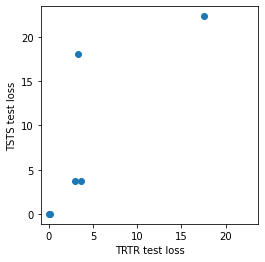

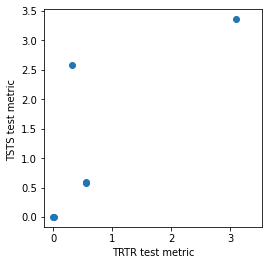

In [20]:
plt.scatter(TRTR_results['test_loss'], TSTS_results['test_loss'])
plt.xlabel('TRTR test loss')
plt.ylabel('TSTS test loss')
plt.axis('square')
plt.show()

plt.scatter(TRTR_results['test_metric'], TSTS_results['test_metric'])
plt.xlabel('TRTR test metric')
plt.ylabel('TSTS test metric ')
plt.axis('square')
plt.show()

### SRA